# Getting Insight from 2019 StackOverflow Survey Data 

Stack Overflow’s annual Developer Survey is the largest and most comprehensive survey of people who code around the world. Each year, State Overflow's field a survey covering everything from developers’ favorite technologies to their job preferences. In 2019 marks the ninth year Stack Overflow published annual Developer Survey results, and nearly 90,000 developers took the 20-minute survey earlier this year. The Result of this survey could be obtained [here](https://insights.stackoverflow.com/survey/)

## Problem Definition

In this projects I want to understand how stack overflow used by communities to help them in 2019
We will find the answer from this following question:
- How often are people visiting Stack Overflow?
- Why Do Developers Visit Stack Overflow?
- How many times a week people find answers on stack overflow?
- Why peoples are visiting Stack Overflow compared to other platform?

## Data Understanding

To Answer those 4 questions, we will only import specific column.

In [155]:
# Import Library\
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Notebook Setup
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', 25)

In [156]:
def import_data(file_path,column_list=None):
    ''' 
    Function:
        This function use to import selected data to workspace
    
    Args:
        file_name: string file path location
        column_list: list of selected column to import, if none will import all
    
    Return:
        dataframe from data sources
    '''
        
    df = pd.read_csv(file_path)
    
    if column_list is not None:
        df = df[column_list]    
    
    return df

In [157]:
# import dataset
path = '../data/survey_results_public.csv'
column_list =['Respondent','SOVisitFreq','SOVisitTo','SOTimeSaved']
df = import_data(path, column_list)
df.head()

,Respondent,SOVisitFreq,SOVisitTo,SOTimeSaved
0,1,A few times per month or weekly,Find answers to specific questions;Learn how t...,Stack Overflow was much faster
1,2,Daily or almost daily,Find answers to specific questions;Learn how t...,Stack Overflow was much faster
2,3,A few times per week,Find answers to specific questions;Learn how t...,They were about the same
3,4,Daily or almost daily,Find answers to specific questions;Pass the ti...,Stack Overflow was much faster
4,5,Multiple times per day,Find answers to specific questions,Stack Overflow was much faster


In [158]:
def data_summaries(df, pred=None):
    """ 
    Purposes:
        - This function used to print summary of the data
    
    Args:
        - df = dataframe that will be describes
        - pred = Target column tha will be predict
        
    Output:
        - 

    Return:
        - None

    """
    obs = df.shape[0]
    types = df.dtypes
    row_counts = df.count()
    uniques = df.nunique()
    missing_values = df.isna().sum()
    missing_ratio = (df.isna().sum()/ obs) * 100
    distinct_values = df.apply(lambda x: [x.unique()])
    skewness = df.skew()
    kurtosis = df.kurt()
    stat = df.describe().round(2).T
    
    print ("DATA SUMMARIES")
    print ("\n----- Data Shape -----\n")
    print('Total Rows:', df.shape[0])
    print('Total Columns:', df.shape[1])
    print('Duplicate Records:', df.duplicated().sum())
    
    overview_cols = ['types', 'counts', 'distincts', 'missing count', 'missing ratio', 'distinct values']
    overview = pd.concat([types, row_counts, uniques, missing_values, missing_ratio, distinct_values], axis = 1)
    overview.columns = overview_cols
    
    if pred is None:
        stat_cols = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis']
        data_stat = pd.concat([stat['mean'], stat['std'], stat['min'], stat['25%'], stat['50%'], stat['75%'], stat['max'],skewness, kurtosis], axis = 1, join = 'inner')

    else:
        corr = df.corr()[pred]
        data_stat = pd.concat([stat['mean'], stat['std'], stat['min'], stat['25%'], stat['50%'], stat['75%'], stat['max'],skewness, kurtosis,corr], axis = 1, join = 'inner')
        corr_col = 'corr '  + pred
        stat_cols = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis', corr_col ]
    
    data_stat.columns = stat_cols
    
    print('\n----- Data Overview -----\n')
    display(overview.sort_values('missing ratio', ascending = False))
    print('\n----- Descriptive Statistics -----\n')
    display(data_stat)

In [159]:
# Data Summaries
data_summaries(df)

DATA SUMMARIES

----- Data Shape -----

Total Rows: 88883
Total Columns: 4
Duplicate Records: 0

----- Data Overview -----



,types,counts,distincts,missing count,missing ratio,distinct values
SOTimeSaved,object,86344,5,2539,2.856564,"[[Stack Overflow was much faster, They were ab..."
SOVisitTo,object,88086,63,797,0.896684,[[Find answers to specific questions;Learn how...
SOVisitFreq,object,88263,6,620,0.697546,"[[A few times per month or weekly, Daily or al..."
Respondent,int64,88883,88883,0,0.000000,"[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1..."



----- Descriptive Statistics -----



,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Respondent,44442.0,25658.46,1.0,22221.5,44442.0,66662.5,88883.0,0.0,-1.2


Observing from the above data summary, there are missing values on All column except Respondent. Thus in the next section we will deal with the missing values

## Data Preparation

In this step we will:
- Handling Missing Values
- Handling SOVisitTo where have multiple answer in one columns

### Handling Missing Values

Since this is a survey results. The null value here are represented as the respondent not answer the question. 
So, I decided to impute the missing values with 'Not Answer'

In [160]:
# Clone Dataframe for Preparation
df_prep = df

In [161]:
df_prep = df_prep.fillna('Not Answered')

In [162]:
df_prep.isna().sum()

Respondent     0
SOVisitFreq    0
SOVisitTo      0
SOTimeSaved    0
dtype: int64

Finaly there are no missing values in our data

### Cleaning People Reasons

In [163]:
# find of different answer
answers = []
for val in df_prep.SOVisitTo:
    try:
        answers.extend(val.split(';'))
    except AttributeError:
        pass

# we end up needing this later
answers = set(answers)
print("The number of answers is {}.".format(len(answers)))
answers

The number of answers is 7.


{'Contribute to a library of information',
 'Find answers to specific questions',
 'Get a sense of belonging to the developer community',
 'Learn how to do things I didn’t necessarily look for',
 'Meet other people with similar skills or interests',
 'Not Answered',
 'Pass the time / relax'}

In [164]:
# Function to split and return values for columns
def split_answer(val):
    try:
        if val.find(ans) >-1:
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# Apply function for each genre
for ans in answers:        
    df_prep[ans] = df_prep['SOVisitTo'].apply(split_answer)

In [165]:
df_prep.head()

,Respondent,SOVisitFreq,SOVisitTo,SOTimeSaved,Contribute to a library of information,Get a sense of belonging to the developer community,Meet other people with similar skills or interests,Not Answered,Find answers to specific questions,Pass the time / relax,Learn how to do things I didn’t necessarily look for
0,1,A few times per month or weekly,Find answers to specific questions;Learn how t...,Stack Overflow was much faster,0,0,0,0,1,0,1
1,2,Daily or almost daily,Find answers to specific questions;Learn how t...,Stack Overflow was much faster,0,0,0,0,1,0,1
2,3,A few times per week,Find answers to specific questions;Learn how t...,They were about the same,0,0,0,0,1,0,1
3,4,Daily or almost daily,Find answers to specific questions;Pass the ti...,Stack Overflow was much faster,0,0,0,0,1,1,0
4,5,Multiple times per day,Find answers to specific questions,Stack Overflow was much faster,0,0,0,0,1,0,0


In [166]:
df_cleaned = df_prep

## Data Analysis

### How often are people visiting Stack Overflow?

In [167]:
def create_columnchart(df,feature,title):
    '''
    Purpose:
        Create a boxplot comparing survey answer results
    Args:
        df: dataframe
        feature: string of single column name that will be compared
        title: chart title
    Output:
        column chart compared survey answers by percentage
    '''


    sns.set(font_scale=1.2)

    f, ax = plt.subplots(figsize=(20, 8))

    g = sns.barplot(x = df[feature].value_counts()/len(df_cleaned)*100, 
                    y = df[feature].value_counts().index ,
                    color = 'royalblue'
                    )

    ax.set(title = title + '\n')
    plt.xlabel('Value in Percent')

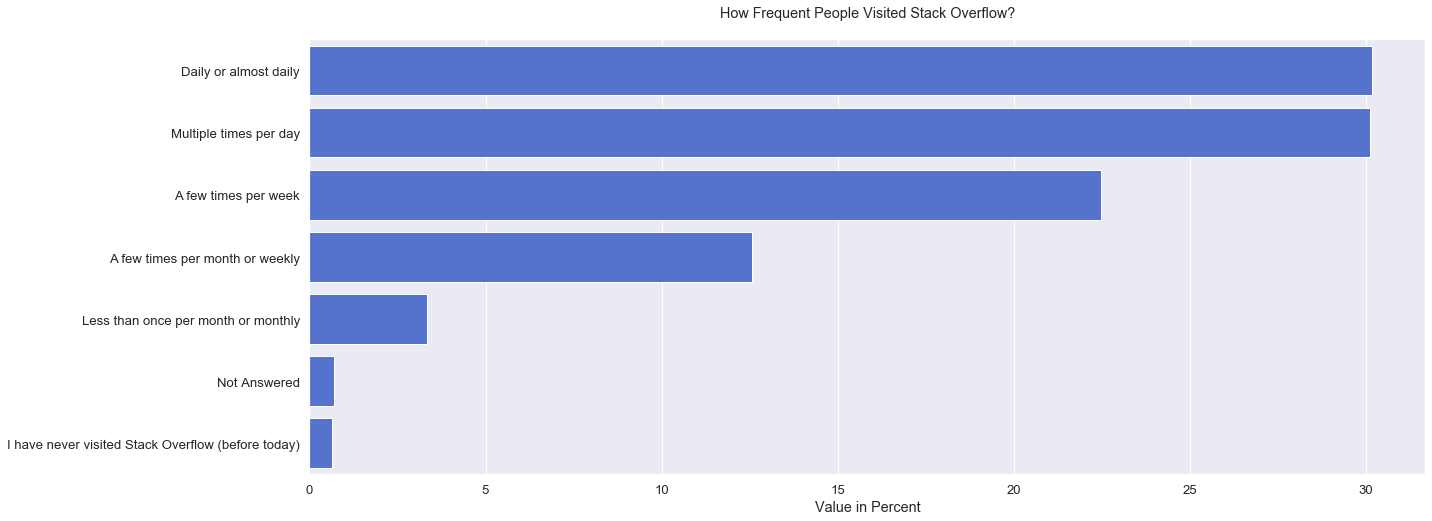

In [168]:
create_columnchart(df_cleaned,'SOVisitFreq','How Frequent People Visited Stack Overflow?')

Most Peoples are visited Daily or Multiple times per day. This contributes around 60% from the toal answers. This indicates that Stack Overflow are very active community.

### Why Do Developers Visit Stack Overflow?


Text(0.5, 0, 'Value in Percent')

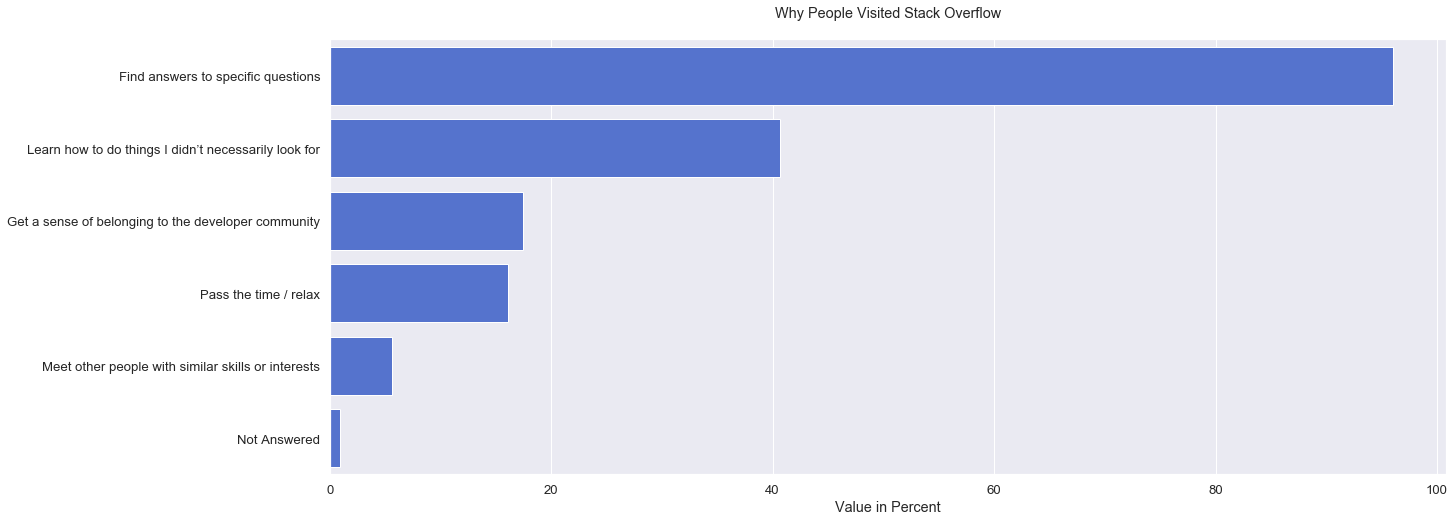

In [169]:
# Prepare Data

df_stacked = df_cleaned.iloc[:,5:]
df_stacked.head()

# Plotting

sns.set(font_scale=1.2)

f, ax = plt.subplots(figsize=(20, 8))

g = sns.barplot(x = (df_stacked.sum(axis = 0)/len(df_cleaned)*100).sort_values(ascending = False), 
                y = (df_stacked.sum(axis = 0)/len(df_cleaned)*100).sort_values(ascending = False).index ,
                color = 'royalblue',                
                )

ax.set(title = 'Why People Visited Stack Overflow\n')
plt.xlabel('Value in Percent')

Almost all people in the survey are visited Stack Overflow to find answer to specific question. Other things that people do are learn how to do things that they didn't neccessarily need yet. Then peoples also want to contribute to a library of information. From here we can say that stack overflow are become go to platform to find answer for developers.

## How is Stack Overflow compared to other Platform

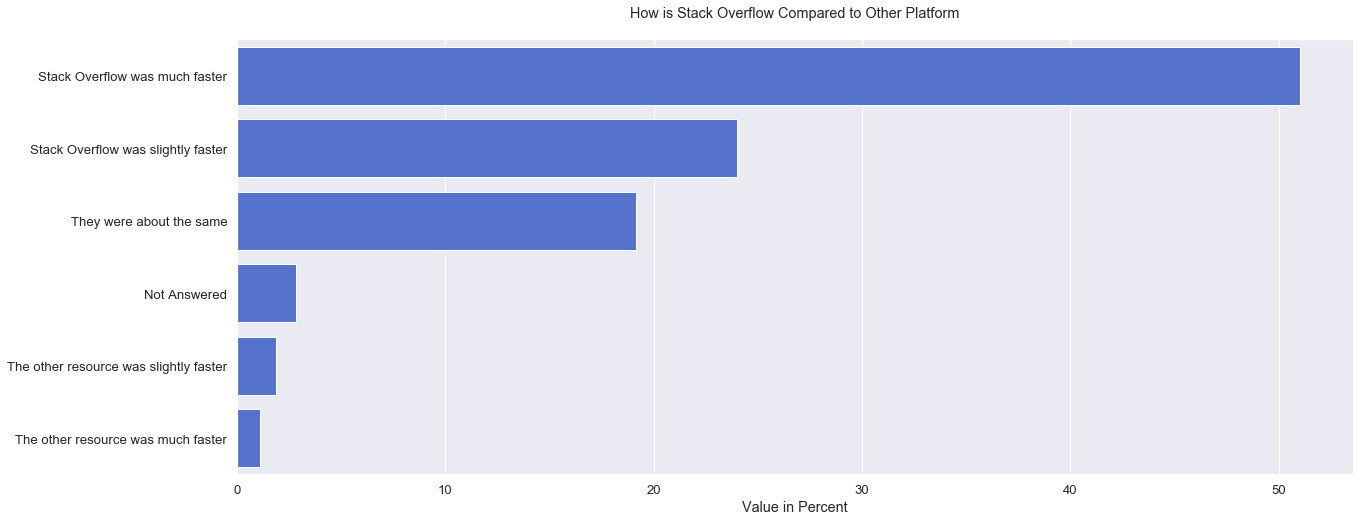

In [170]:
create_columnchart(df_cleaned,'SOTimeSaved','How is Stack Overflow Compared to Other Platform')

Majority of people are said that stack overflow are was much faster. This is the difference between the other resource. Thats confirm why people tend to choose Stack Overflow not other platform.

## Conslusion

In summary We could Answer All our Question using this data

- __How often are people visiting Stack Overflow?__  
Most Peoples are visited Daily or Multiple times per day. This contributes around 60% from the toal answers. This indicates that Stack Overflow are very active community.

- __Why Do Developers Visit Stack Overflow?__  
Almost all people in the survey are visited Stack Overflow to find answer to specific question. Other things that people do are learn how to do things that they didn't neccessarily need yet. Then peoples also want to contribute to a library of information. From here we can say that stack overflow are become go to platform to find answer for developers.

- __Why peoples are visiting Stack Overflow compared to other platform?__  
Majority of people are said that stack overflow are was much faster. This is the difference between the other resource. Thats confirm why people tend to choose Stack Overflow not other platform.